## Importation des librairies

In [2]:
import numpy as np
import pandas as pd
import gc
import time
import re
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

### Le codage one-hot sur les colonnes catégorielles de la DataFrame

In [3]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    # Crée de nouvelles colonnes binaires pour chaque valeur unique présente dans "categorical_columns"
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    # Crée une liste contenant les noms des nouvelles colonnes générées par l'encodage one-hot
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

## Prétraitement des données

In [4]:
df = pd.read_csv(r"C:\Users\dmedc\Documents\DATA SCIENCE\PROJET\Projet 7\data\application_train.csv")
test_df = pd.read_csv(r"C:\Users\dmedc\Documents\DATA SCIENCE\PROJET\Projet 7\data\application_test.csv")
print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
df = df.append(test_df).reset_index()

Train samples: 307511, test samples: 48744


In [5]:
df.head()

,index,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df.shape

(356255, 123)


### 2.1) application_train.csv and application_test.csv

In [7]:
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(r"C:\Users\dmedc\Documents\DATA SCIENCE\PROJET\Projet 7\data\application_train.csv", nrows= num_rows)
    test_df = pd.read_csv(r"C:\Users\dmedc\Documents\DATA SCIENCE\PROJET\Projet 7\data\application_test.csv", nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    
    # Optional: 
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        #  attribue un entier unique à chaque catégorie dans la colonne bin_feature 
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    del test_df
    gc.collect()
    return df

In [8]:
df = application_train_test()
df.head(3)

Train samples: 307511, test samples: 48744


,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,0,1,0,1,0,0.067329,0.498036,202500.0,0.121978,0.060749
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,0,0,0,1,0,0.070862,0.208736,135000.0,0.132217,0.027598
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0.011814,0.500000,67500.0,0.100000,0.050000


### 2.2) bureau.csv and bureau_balance.csv

In [9]:
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(r"C:\Users\dmedc\Documents\DATA SCIENCE\PROJET\Projet 7\data\bureau.csv", nrows = num_rows)
    bb = pd.read_csv(r"C:\Users\dmedc\Documents\DATA SCIENCE\PROJET\Projet 7\data\bureau_balance.csv", nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    # modifie les noms des colonnes du DataFrame bb_agg :
    #en combinant le nom de la colonne d'origine avec l'opération d'agrégation correspondante en majuscules.
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    # Fusionne les données agrégées (bb_agg) avec le DataFrame bureau
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    # Effectuer une collecte forcée des objets inutilisés en mémoire et libérer de l'espace
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    bureau_agg = bureau_agg.reset_index()
    
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [10]:
bureau_agg = bureau_and_balance()
bureau_agg.head(3)

,SK_ID_CURR,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,...,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_MAX,CLOSED_AMT_ANNUITY_MEAN,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_MIN_MIN,CLOSED_MONTHS_BALANCE_MAX_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,CLOSED_MONTHS_BALANCE_SIZE_SUM
0,100001,-1572,-49,-735.00,240043.666667,-1329.0,1778.0,82.428571,-93.142857,0,...,0.0,0.0,0.0,0.0,0.0,0.0,-51.0,0.0,35.0,140.0
1,100002,-1437,-103,-874.00,186150.000000,-1072.0,780.0,-349.000000,-499.875000,0,...,0.0,0.0,0.0,0.0,0.0,0.0,-47.0,0.0,15.0,90.0
2,100003,-2586,-606,-1400.75,827783.583333,-2434.0,1216.0,-544.500000,-816.000000,0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0


### 2.3) previous_applications.csv

In [11]:
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(r"C:\Users\dmedc\Documents\DATA SCIENCE\PROJET\Projet 7\data\previous_application.csv", nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True) # Applique un encodage one-hot aux colonnes catégorielles du DataFrame
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True) # Remplace les valeurs "365243" par NaN dans certaines colonnes 
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features : Effectue des agrégations numériques (min, max, moyenne, variance, somme) sur certaines colonnes numériques
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features : Effectue des agrégations catégorielles (moyenne) sur toutes les colonnes catégorielles
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    # regrouper les données du DataFrame prev par la colonne 'SK_ID_CURR' (identifiant de l'emprunteur)
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    # renomme les colonnes de prev_agg en ajoutant le préfixe "PREV_" suivi du nom de la colonne d'origine et du type d'agrégation (en majuscules)
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # # Previous Applications: Approved Applications - only numerical features
    # Crée un sous-ensemble du DataFrame prev en sélectionnant uniquement les lignes où la colonne 
    # 'NAME_CONTRACT_STATUS_Approved' a une valeur de 1 (pour les applications approuvées).
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    # effectue des agrégations sur le sous-ensemble approved en regroupant les données 
    # par 'SK_ID_CURR' et en utilisant les agrégations spécifiées dans num_aggregations.
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    # renomme les colonnes de approved_agg en ajoutant le préfixe "APPROVED_"
    # suivi du nom de la colonne d'origine et du type d'agrégation (en majuscules).
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    # effectue une jointure (fusion) entre prev_agg et approved_agg en utilisant la colonne 'SK_ID_CURR'
    # comme clé de jointure. La jointure est effectuée à gauche (how='left')
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')

    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    prev_agg = prev_agg.reset_index()
    
    # suppriment les DataFrames pour libérer de la mémoire.
    del refused, refused_agg, approved, approved_agg, prev
    # collecte de garbage pour libérer davantage de mémoire en supprimant les objets inutilisés
    gc.collect()
    return prev_agg

In [12]:
prev_agg = previous_applications()
prev_agg.head(3)

,SK_ID_CURR,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,...,REFUSED_HOUR_APPR_PROCESS_START_MAX,REFUSED_HOUR_APPR_PROCESS_START_MEAN,REFUSED_RATE_DOWN_PAYMENT_MIN,REFUSED_RATE_DOWN_PAYMENT_MAX,REFUSED_RATE_DOWN_PAYMENT_MEAN,REFUSED_DAYS_DECISION_MIN,REFUSED_DAYS_DECISION_MAX,REFUSED_DAYS_DECISION_MEAN,REFUSED_CNT_PAYMENT_MEAN,REFUSED_CNT_PAYMENT_SUM
0,100001,3951.000,3951.000,3951.000,24835.5,24835.5,24835.5,23787.0,23787.0,23787.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100002,9251.775,9251.775,9251.775,179055.0,179055.0,179055.0,179055.0,179055.0,179055.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100003,6737.310,98356.995,56553.990,68809.5,900000.0,435436.5,68053.5,1035882.0,484191.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.4) POS_CASH_balance.csv

In [13]:
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(r"C:\Users\dmedc\Documents\DATA SCIENCE\PROJET\Projet 7\data\POS_CASH_balance.csv")
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    pos_agg = pos_agg.reset_index()
    del pos
    gc.collect()
    return pos_agg

In [14]:
pos_agg = pos_cash()
pos_agg.head(3)

,SK_ID_CURR,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN,POS_NAME_CONTRACT_STATUS_nan_MEAN,POS_COUNT
0,100001,-53,-72.555556,9,7,0.777778,7,0.777778,0.777778,0.0,0.0,0.0,0.222222,0.0,0.0,0.0,0.0,0.0,9
1,100002,-1,-10.000000,19,0,0.000000,0,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,19
2,100003,-18,-43.785714,28,0,0.000000,0,0.000000,0.928571,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,28


### 2.5)  installments_payments.csv

In [15]:
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(r"C:\Users\dmedc\Documents\DATA SCIENCE\PROJET\Projet 7\data\installments_payments.csv", nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    ins_agg = ins_agg.reset_index()
    
    del ins
    gc.collect()
    return ins_agg

In [16]:
ins_agg = installments_payments()
ins_agg.head(3)

,SK_ID_CURR,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,100001,2,11.0,1.571429,11.0,36.0,8.857143,62.0,1.0,1.0,...,5885.132143,41195.925,3951.000,17397.900,5885.132143,41195.925,-1628.0,-2195.000000,-15365.0,7
1,100002,2,0.0,0.000000,0.0,31.0,20.421053,388.0,1.0,1.0,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19
2,100003,2,0.0,0.000000,0.0,14.0,7.160000,179.0,1.0,1.0,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25


### 2.6) credit_card_balance.csv

In [17]:
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(r"C:\Users\dmedc\Documents\DATA SCIENCE\PROJET\Projet 7\data\credit_card_balance.csv", nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    cc_agg = cc_agg.reset_index()
    
    del cc
    gc.collect()
    return cc_agg

In [18]:
cc_agg = credit_card_balance()
cc_agg.head(3)

,SK_ID_CURR,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_VAR,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100006,-6,-1,-3.5,-21,3.5,0.0,0.00,0.000000,0.000,...,0,0.0,0,0.0,0,0,0.0,0,0.0,6
1,100011,-75,-2,-38.5,-2849,462.5,0.0,189000.00,54482.111149,4031676.225,...,0,0.0,0,0.0,0,0,0.0,0,0.0,74
2,100013,-96,-1,-48.5,-4656,776.0,0.0,161420.22,18159.919219,1743352.245,...,0,0.0,0,0.0,0,0,0.0,0,0.0,96


## Préparation des données

### 3.1) La consolidation des informations importantes sur le client

In [5]:
df = pd.read_csv(r"C:\Users\dmedc\Documents\DATA SCIENCE\PROJET\Projet 7\data\application_train.csv")
test_df = pd.read_csv(r"C:\Users\dmedc\Documents\DATA SCIENCE\PROJET\Projet 7\data\application_test.csv")
df = pd.concat([df, test_df]).reset_index()

df = df.loc[:, ['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER','CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'AMT_INCOME_TOTAL', 'AMT_CREDIT']]
df.head(3)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,CNT_CHILDREN,CNT_FAM_MEMBERS,AMT_INCOME_TOTAL,AMT_CREDIT
0,100002,Cash loans,M,0,1.0,202500.0,406597.5
1,100003,Cash loans,F,0,2.0,270000.0,1293502.5
2,100004,Revolving loans,M,0,1.0,67500.0,135000.0


In [22]:
# Exporter le fichier
df.to_csv(".\info_clients.csv", index=False)

### 3.2) La consolidation des données transformées

In [23]:
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.merge(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.merge(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.merge(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.merge(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.merge(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    with timer("DataFrame Final :"):
        df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        print("DataFrame Final df:", df.shape)
    return df

In [24]:
df = main()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 117)
Process bureau and bureau_balance - done in 55s
Previous applications df shape: (338857, 250)
Process previous_applications - done in 54s
Pos-cash balance df shape: (337252, 19)
Process POS-CASH balance - done in 39s
Installments payments df shape: (339587, 27)
Process installments payments - done in 86s
Credit card balance df shape: (103558, 142)
Process credit card balance - done in 48s
DataFrame Final df: (356251, 798)
DataFrame Final : - done in 7s


In [25]:
df.head(3)

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# # Exporter le fichier
# df.to_csv(".\data.csv",index=False)

### 3.3) La Séparation des données X, y

In [27]:
data = pd.read_csv(".\data.csv")
# Réduire au dixième la taille de nos données
df = data.sample(frac=0.1)

In [28]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

Starting LightGBM. Train shape: (30815, 798), test shape: (4810, 798)


In [29]:
# Séparer les caractéristiques et la variable cible
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df[feats]
y = train_df['TARGET']

In [30]:
print("Nbre NaN de X: {}, Nbre NaN de y: {}".format(X.isnull().sum().sum(), y.isnull().sum().sum()))

Nbre NaN de X: 6376652, Nbre NaN de y: 0


In [31]:
# Remplacer les NaN par la moyenne de chaque colonne
X = X.fillna(X.mean())
# Replacer les infinite values par a large finite number
X = X.replace([np.inf, -np.inf], 1e9)

## Modélisation LightGBM GBDT with KFold or Stratified KFold

In [32]:
# Définir le nombre de folds pour la validation croisée
num_folds = 5
stratified = False

# Créer les folds pour la validation croisée
if stratified:
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
else:
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)

### 4.1) Modèle avec déséquilibre des classe

#### algorithme

In [33]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Initialiser tableaux et dataframes pour stocker les resultats
oof_preds = np.zeros(X.shape[0])
y_pred = np.zeros(X.shape[0])
feature_importance_df = pd.DataFrame()

# Début de la boucle de validation croisée
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
     # Séparer les données d'entraînement et de validation pour ce fold
    train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
    valid_x, valid_y = X.iloc[valid_idx], y.iloc[valid_idx]

    # LightGBM parameters found by Bayesian optimization
    clf = LGBMClassifier(
        nthread=4,
        n_estimators=10000,
        learning_rate=0.02,
        num_leaves=34,
        colsample_bytree=0.9497036,
        subsample=0.8715623,
        max_depth=8,
        reg_alpha=0.041545473,
        reg_lambda=0.0735294,
        min_split_gain=0.0222415,
        min_child_weight=39.3259775,
        silent=-1,
        verbose=-1, )

    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
        eval_metric= 'auc')

    # La prédiction des probabilités des classes (avec l'indice 1) pour les données de validation
    oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
    y_pred[valid_idx] = clf.predict(valid_x)
    
    # La features importances 
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    
    del train_x, train_y, valid_x, valid_y
    gc.collect()

Fold  1 AUC : 0.743096
Fold  2 AUC : 0.729207
Fold  3 AUC : 0.732330
Fold  4 AUC : 0.740854
Fold  5 AUC : 0.758962


#### Evaluation

In [34]:
AUC = roc_auc_score(y, oof_preds)
Accuracy = accuracy_score(y, y_pred)

print('Full AUC score %.6f' % AUC)
print('Full Accuracy score %.6f' % Accuracy)

Full AUC score 0.740592
Full Accuracy score 0.916859


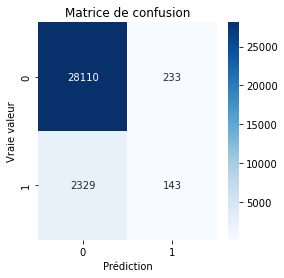

In [35]:
from sklearn.metrics import confusion_matrix

# Calculer la matrice de confusion
cm = confusion_matrix(y, y_pred)

# Afficher la matrice de confusion
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Matrice de confusion')
plt.xlabel('Prédiction')
plt.ylabel('Vraie valeur')
plt.show()

### 4.2) Modèle avec l'équilibrage des données par SMOTE 

In [37]:
# Sélection des lignes avec des valeurs infinies
rows_with_inf = df[df.isin([np.inf, -np.inf]).any(axis=1)]

In [38]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter

In [39]:
from imblearn.over_sampling import SMOTE

# Instancier l'objet SMOTE
smote = SMOTE(sampling_strategy="auto")

# Appliquer SMOTE pour générer des échantillons synthétiques
X_smote, y_smote = smote.fit_resample(X, y)

# Sélectionner aléatoirement le nombre initial de client
X_smote = X_smote.sample(n=X.shape[0], random_state=42)
y_smote = y_smote.sample(n=X.shape[0], random_state=42)

counter = Counter(y)

print("Avant SMOTE X :", X.shape[0])
print("Avant SMOTE X:", X_smote.shape[0])

print("Avant SMOTE y :", Counter(y))
print("Après SMOTE y:", Counter(y_smote))

Avant SMOTE X : 30815
Avant SMOTE X: 30815
Avant SMOTE y : Counter({0.0: 28343, 1.0: 2472})
Après SMOTE y: Counter({1.0: 15442, 0.0: 15373})


In [40]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Initialiser tableaux et dataframes pour stocker les resultats
oof_preds = np.zeros(X.shape[0])
y_pred = np.zeros(X.shape[0])
feature_importance_df = pd.DataFrame()

# Début de la boucle de validation croisée
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
     # Séparer les données d'entraînement et de validation pour ce fold
    train_x, train_y = X_smote.iloc[train_idx], y_smote.iloc[train_idx]
    valid_x, valid_y = X.iloc[valid_idx], y.iloc[valid_idx]

    # LightGBM parameters found by Bayesian optimization
    clf_smote = LGBMClassifier(
        nthread=4,
        n_estimators=10000,
        learning_rate=0.02,
        num_leaves=34,
        colsample_bytree=0.9497036,
        subsample=0.8715623,
        max_depth=8,
        reg_alpha=0.041545473,
        reg_lambda=0.0735294,
        min_split_gain=0.0222415,
        min_child_weight=39.3259775,
        silent=-1,
        verbose=-1, )

    clf_smote.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
        eval_metric= 'auc')

    # La prédiction des probabilités des classes (avec l'indice 1) pour les données de validation
    oof_preds[valid_idx] = clf_smote.predict_proba(valid_x, num_iteration=clf_smote.best_iteration_)[:, 1]
    y_pred[valid_idx] = clf_smote.predict(valid_x)
    
    # La features importances 
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df_smote = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    
    del train_x, train_y, valid_x, valid_y
    gc.collect()


Fold  1 AUC : 0.861958
Fold  2 AUC : 0.892156
Fold  3 AUC : 0.870606
Fold  4 AUC : 0.885317
Fold  5 AUC : 0.876533


#### Evaluation

In [41]:
AUC_smote = roc_auc_score(y, oof_preds)
Accuracy_smote = accuracy_score(y, y_pred)

print('Full AUC score %.6f' % AUC_smote)
print('Full Accuracy score %.6f' % Accuracy_smote)

Full AUC score 0.876859
Full Accuracy score 0.952036


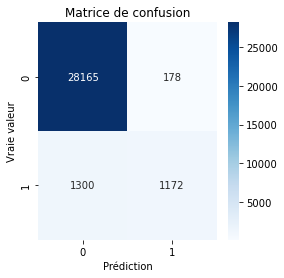

In [42]:
from sklearn.metrics import confusion_matrix

# Calculer la matrice de confusion
cm = confusion_matrix(y, y_pred)

# Afficher la matrice de confusion
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Matrice de confusion')
plt.xlabel('Prédiction')
plt.ylabel('Vraie valeur')
plt.show()

### 4.3) Modèle par Implémentation d'un score métier pour prioriser le FN

In [44]:
import lightgbm as lgb
from sklearn.metrics import make_scorer

# Définir les coûts de FP et FN
cost_fp = 1.0
cost_fn = 10.0

#### algorithme

In [45]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Initialiser tableaux et dataframes pour stocker les resultats
oof_preds = np.zeros(X.shape[0])
y_pred = np.zeros(X.shape[0])
feature_importance_df = pd.DataFrame()

# Début de la boucle de validation croisée
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
     # Séparer les données d'entraînement et de validation pour ce fold
    train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
    valid_x, valid_y = X.iloc[valid_idx], y.iloc[valid_idx]

    # LightGBM parameters found by Bayesian optimization
    clf_FN = LGBMClassifier(
        nthread=4,
        n_estimators=10000,
        learning_rate=0.02,
        num_leaves=34,
        colsample_bytree=0.9497036,
        subsample=0.8715623,
        max_depth=8,
        reg_alpha=0.041545473,
        reg_lambda=0.0735294,
        min_split_gain=0.0222415,
        min_child_weight=39.3259775,
        silent=-1,
        verbose=-1, )

    # Appliquer les coûts aux étiquettes d'entraînement
    weights = np.where(train_y == 1, cost_fp, cost_fn)

    # Créer le jeu de données d'entraînement avec les poids
    train_data = lgb.Dataset(train_x, label=train_y, weight=weights)

    clf_FN.fit(train_x, train_y , sample_weight=weights, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
        eval_metric= 'custom_scorer')

    # La prédiction des probabilités des classes (avec l'indice 1) pour les données de validation
    oof_preds[valid_idx] = clf_FN.predict_proba(valid_x, num_iteration=clf_FN.best_iteration_)[:, 1]
    y_pred[valid_idx] = clf_FN.predict(valid_x)
    
    # La features importances 
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df_FN = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    
    del train_x, train_y, valid_x, valid_y
    gc.collect()

Fold  1 AUC : 0.742259
Fold  2 AUC : 0.727943
Fold  3 AUC : 0.732619
Fold  4 AUC : 0.740654
Fold  5 AUC : 0.754672


#### Evaluation

In [46]:
AUC_FN = roc_auc_score(y, oof_preds)
Accuracy_FN = accuracy_score(y, y_pred)

print('Full AUC score %.6f' % AUC_FN)
print('Full Accuracy score %.6f' % Accuracy_FN)

Full AUC score 0.739384
Full Accuracy score 0.919650


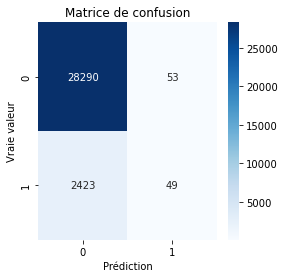

In [47]:
from sklearn.metrics import confusion_matrix

# Calculer la matrice de confusion
cm = confusion_matrix(y, y_pred)

# Afficher la matrice de confusion
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Matrice de confusion')
plt.xlabel('Prédiction')
plt.ylabel('Vraie valeur')
plt.show()

## Tableau  d'évaluation des  performances 

In [57]:
Performance_Table = pd.DataFrame({
    
    'Métrique' : ['AUC', 'Acuuracy'],
    "Modèle avec deséquilibre" : [AUC_FN, Accuracy],
    "Modèle équilibré par SMOTE" : [AUC_smote, Accuracy_smote],
    "Modèle avec score métier" : [AUC_FN, Accuracy_FN]
})

Performance_Table

,Métrique,Modèle avec deséquilibre,Modèle équilibré par SMOTE,Modèle avec score métier
0,AUC,0.739384,0.876859,0.739384
1,Acuuracy,0.916859,0.952036,0.919650


## Feature Importance

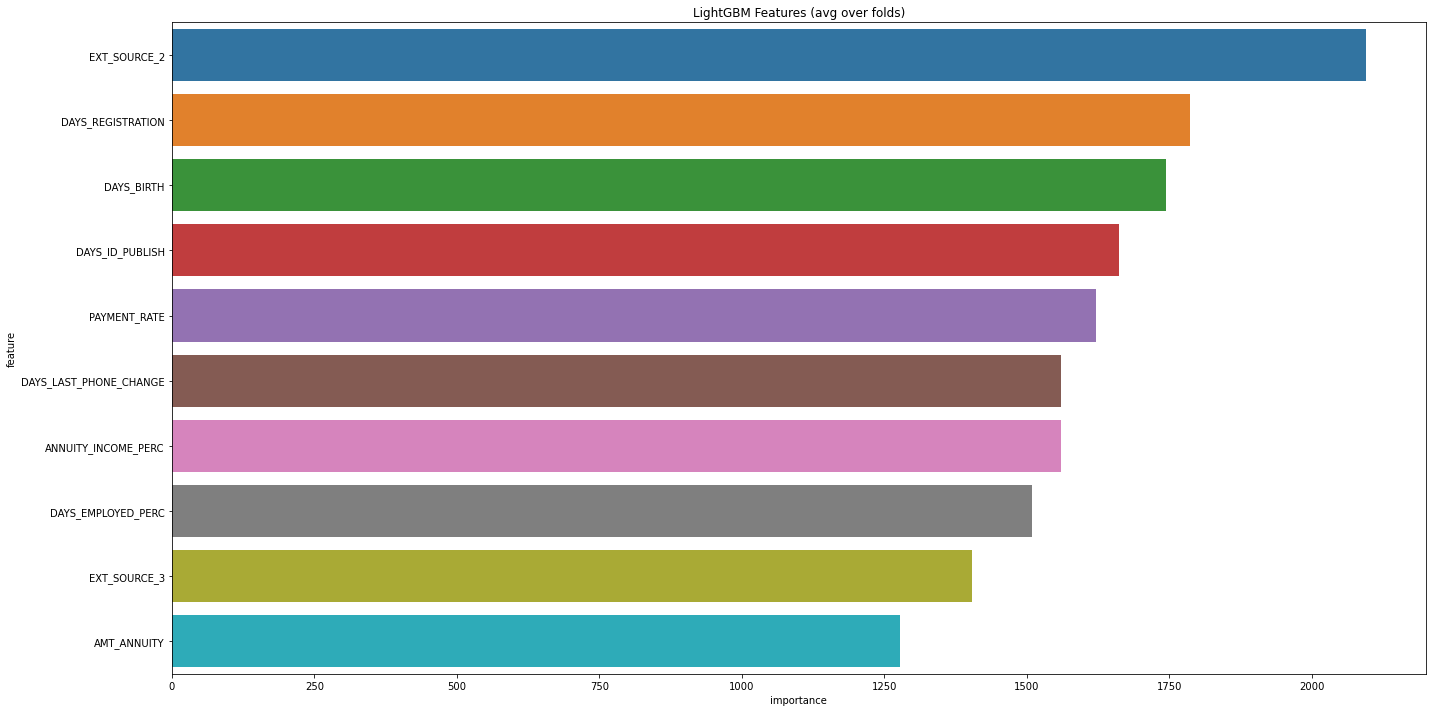

In [43]:
cols = feature_importance_df_smote[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:10].index
best_features = feature_importance_df_smote.loc[feature_importance_df.feature_smote.isin(cols)]
plt.figure(figsize=(20, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

## Enregistrement du modèle en local avec MLflow

In [49]:
import mlflow
import mlflow.lightgbm

# Démarrer une nouvelle exécution MLflow
with mlflow.start_run():
    # Chemin d'accès local où vous souhaitez enregistrer le modèle
    local_path = r"C:\Users\dmedc\Documents\DATA SCIENCE\PROJET\Projet 7\kernel\modele"
    
    # Stocker le modèle avec MLflow en local
    #mlflow.sklearn.save_model(clf_smote, local_path)
    mlflow.lightgbm.log_model(model, "model")
    mlflow.lightgbm.save_model(model, local_path)
    print(f"Modèle enregistré localement à l'emplacement {local_path}")

2024/06/04 10:43:06 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\dmedc\Documents\DATA SCIENCE\PROJET\Projet 7\kernel\modele\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.0.2', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
C:\Users\dmedc\anaconda3\lib\site-packages\_distutils_hack\__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Modèle enregistré localement à l'emplacement C:\Users\dmedc\Documents\DATA SCIENCE\PROJET\Projet 7\kernel\modele
